In [87]:
import pandas as pd
from lib import create_portfolio
import numpy as np
import scipy.optimize as sp
import matplotlib.pyplot as plt
import scipy as si

In [2]:
RISK_FREE = 0

In [3]:
data = pd.read_csv("data.csv", index_col=0, header=[0, 1])

In [4]:
# Using Daily Change in price
log_returns = np.log(data["Close"] / data["Close"].shift(1))

# Create Co-variance table
covariance_table = log_returns.cov() * np.sqrt(252)

In [5]:
weights = np.array([1./len(log_returns.columns)] * len(log_returns.columns))

create_portfolio(log_returns, weights, log_returns.cov())

c:\Users\olive\Documents\GitHub\Modern-Portfolio-Theory\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


(Ticker
 AAPL    44.477214
 AMD     32.407002
 KO      10.049685
 MS      37.570371
 MSFT    36.333657
 TSLA    95.208454
 TSM     46.346689
 dtype: float64,
 np.float64(0.2903365115438384))

In [6]:
x_0 = np.array([0.001] * len(log_returns.columns))
args = (log_returns.mean(), covariance_table)
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bound = (0,1)
bounds = [bound for x in range(len(log_returns.columns))]

In [7]:
create_portfolio(log_returns.mean(),np.array([1/7]*7), covariance_table)

(np.float64(0.24056728089733775), np.float64(1.1567827121718437))

In [8]:
def opt_min_risk(weights, returns, co_variance_table):
    return create_portfolio(returns, weights, co_variance_table)[1]


def opt_min_return(weights, returns, co_variance_table):
    return create_portfolio(returns, weights, co_variance_table)[0]

def opt_max_return(weights, returns, co_variance_table):
    return -create_portfolio(returns, weights, co_variance_table)[0]


def opt_max_sharpe(weights, returns, co_variance_table):
    portfolio = create_portfolio(returns, weights, co_variance_table)
    sharpe = (portfolio[0] - RISK_FREE) / (portfolio[1])
    return -sharpe

In [17]:
lowest_risk = sp.minimize(opt_min_risk, x_0, args=args, constraints=constraints, bounds=bounds)
min_return = sp.minimize(opt_min_return, x_0, args=args, constraints=constraints, bounds=bounds)
max_return = sp.minimize(opt_max_return, x_0, args=args, constraints=constraints, bounds=bounds)
max_sharpe = sp.minimize(opt_max_sharpe, x_0, args=args, constraints=constraints, bounds=bounds)

In [18]:
{x: round(y,4) for x,y in zip(log_returns.columns, max_sharpe.x)}

{'AAPL': np.float64(0.3905),
 'AMD': np.float64(0.0),
 'KO': np.float64(0.0),
 'MS': np.float64(0.1511),
 'MSFT': np.float64(0.0),
 'TSLA': np.float64(0.2455),
 'TSM': np.float64(0.2129)}

In [19]:
create_portfolio(log_returns.mean(), max_sharpe.x, covariance_table)

(np.float64(0.3134598277649494), np.float64(0.3305324167675851))

In [20]:
def efficient_optimisation(mean_returns, target_return, covariance_table, days=252):
    """
    Calculates lowest risk for a given target return
    """
    x_0 = np.array([0.01] * len(mean_returns))
    args = (mean_returns, covariance_table)
    bound = (0,1)
    bounds = tuple([bound for _ in range(len(mean_returns))])

    constraints = ({"type": "eq", "fun": lambda x: create_portfolio(mean_returns, x, covariance_table, days)[0] - target_return},
                  {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    
    result = sp.minimize(opt_min_risk, x_0, args, bounds=bounds, constraints=constraints)

    return result

In [40]:
mean_returns = log_returns.mean().values
covariance_table = log_returns.cov().values

# target_returns = np.linspace(create_portfolio(log_returns.mean(), lowest_risk["x"], covariance_table)[0], create_portfolio(log_returns.mean(), max_sharpe["x"], covariance_table)[0], 25) # Top half of efficient frontier
target_returns = np.linspace(mean_returns.min() *252, mean_returns.max() *252, 25) # Includes bottom half of efficient frontier

In [41]:
risk_min_list = []
for target in target_returns:
    res = efficient_optimisation(mean_returns, target, covariance_table)
    if res.success:
        risk_min_list.append(res.fun)


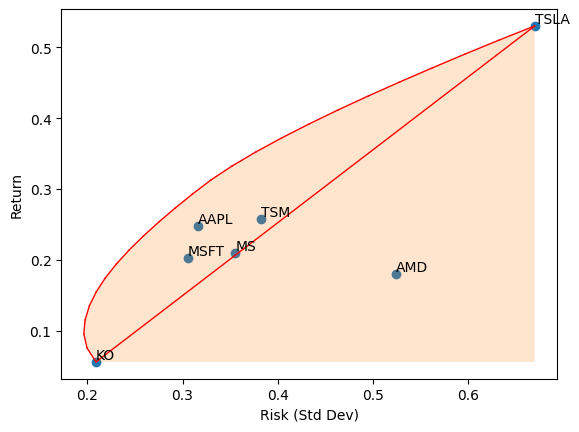

In [ ]:
fig, ax = plt.subplots()

# ax.plot(risk_min_list, target_returns)
ax.scatter(np.sqrt(covariance_table.diagonal()) * np.sqrt(252), mean_returns * 252)

ax.set_xlabel('Risk (Std Dev)')
ax.set_ylabel('Return')

for i, t in enumerate(log_returns.columns):
    ax.text((np.sqrt(covariance_table.diagonal()) * np.sqrt(252))[i],mean_returns[i]*252, t,
        horizontalalignment='left',
        verticalalignment='bottom')


points = np.column_stack([risk_min_list, target_returns])
hull = si.spatial.ConvexHull(points) 

for simplex in hull.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], 'r-', linewidth=1, alpha=1)

ax.fill_between(risk_min_list,target_returns, target_returns.min(), alpha=0.2)